## Лабораторная 5: логистическая регрессия. ROC. AUC. One-hot encoding

## 1
Рассмотрим данные медицинской страховой фирмы. На основе характеристик пациентов `Members.csv` (возраст, пол) и данных о получении медицинского обслуживания в предыдущем году `Claims_Y1.csv` (медицинское учреждение, врач, тип проблемы, количество дней госпитализации, дата, и др. ) нужно предсказать факт госпитализации хотя бы на 1 день в следующем году `DaysInHospital_Y2.csv`.

In [2]:
import pandas as pd

from sklearn import *

%matplotlib inline
import matplotlib.pyplot as plt

Прочтите данные, в качестве параметра index_col используйте `MemberID`. 

* данные из таблицы 'DaysInHospital_Y2.csv' в переменную `days2`
* данные из таблицы 'Members.csv' в переменную `m`
* данные из таблицы 'Claims_Y1.csv' в переменную `claims`

In [3]:
# Загрузка таблицы DaysInHospital_Y2.csv
days2 = pd.read_csv('DaysInHospital_Y2.csv', index_col='MemberID')

# Загрузка таблицы Members.csv
m = pd.read_csv('Members.csv', index_col='MemberID')

# Загрузка таблицы Claims_Y1.csv
claims = pd.read_csv('Claims_Y1.csv')

## 2
Чтобы анонимизировать данные организатор указал приблизительную информацию о пациентах, например в столбце возраст указаны возрастные группы: '0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+'. Преобразуем строковые признаки в количественные и заменим пропущенные значения:

In [21]:
i = pd.notnull(m.AgeAtFirstClaim)
m.loc[i,'AgeAtFirstClaim'] = m.loc[i,'AgeAtFirstClaim'].apply(lambda s: s.split('-')[0] if s!='80+' else '80')
m.loc[i,'AgeAtFirstClaim'] = m.loc[i,'AgeAtFirstClaim'].apply(lambda s: int(s))

m.AgeAtFirstClaim = m.AgeAtFirstClaim.fillna(value=-1)

m.Sex = m.Sex.fillna(value='N')

claims.CharlsonIndex = claims.CharlsonIndex.map({'0':0, '1-2':1, '3-4':3, '5+':5})
claims.LengthOfStay = claims.LengthOfStay.fillna(value=0)
claims.LengthOfStay = claims.LengthOfStay.map({0:0, '1 day':1, '2 days':2, '3 days':3, '4 days':4,\
    '5 days':5, '6 days':6, '1- 2 weeks':10, '2- 4 weeks':21, '4- 8 weeks':42, '26+ weeks':182})

m.head()

,AgeAtFirstClaim,Sex
MemberID,,
14723353,70,M
75706636,70,M
17320609,70,M
69690888,40,M
33004608,0,M


In [23]:
#m.head()
#claims.head()

,MemberID,ProviderID,Vendor,PCP,Year,Specialty,PlaceSvc,PayDelay,LengthOfStay,DSFS,PrimaryConditionGroup,CharlsonIndex,ProcedureGroup,SupLOS
0,42286978,8013252.0,172193.0,37796.0,Y1,Surgery,Office,28,0,8- 9 months,NEUMENT,0,MED,0
1,99829076,6721023.0,265273.0,91972.0,Y1,Rehabilitation,Office,162+,0,0- 1 month,TRAUMA,0,MED,0
2,54666321,9932074.0,35565.0,27294.0,Y1,Diagnostic Imaging,Office,29,0,0- 1 month,RESPR4,0,RAD,0
3,66951188,4699470.0,179509.0,75876.0,Y1,Diagnostic Imaging,Inpatient Hospital,51,0,0- 1 month,ROAMI,0,RAD,0
4,78859054,9121540.0,523791.0,21579.0,Y1,Emergency,Urgent Care,22,1,6- 7 months,HEART2,0,SDS,0


## 3
Сконструируем признаки по массиву случаев медицинского обслуживания: 
* `f_Charlson` — максимальный индекс коморбидности Чальсона по всем случаям для пациента (`CharlsonIndex` в таблице `claims`)
* `f_LengthOfStay` — суммарное количество дней госпитализации в прошлом году (`LengthOfStay` в таблице `claims`) 

*Функции, которые могут пригодиться при решении: `.groupby(['MemberID']), .max(), .sum()`* 

In [24]:
claims['CharlsonIndex'] = claims['CharlsonIndex'].fillna(0)  # заменим пропуски на 0

f_Charlson = claims.groupby(['MemberID'])['CharlsonIndex'].max().reset_index()
f_Charlson = f_Charlson.rename(columns={'CharlsonIndex': 'f_Charlson'})

f_LengthOfStay = claims.groupby(['MemberID'])['LengthOfStay'].sum().reset_index()
f_LengthOfStay = f_LengthOfStay.rename(columns={'LengthOfStay': 'f_LengthOfStay'})

features = m[['AgeAtFirstClaim', 'Sex']] \
           .merge(f_Charlson, on='MemberID', how='left') \
           .merge(f_LengthOfStay, on='MemberID', how='left')

## 4

Составим матрицу объектов признаков со столбцами: `f_Charlson`, `f_LengthOfStay`, возраст пациента, `ClaimsTruncated` (не оказалось ли случаев медицинского обслуживания слишком много):

*Функции, которые могут пригодиться при решении: `.join()`*

In [50]:
data = pd.merge(m, claims.groupby('MemberID').agg({'CharlsonIndex': 'max', 'LengthOfStay': 'sum'}), on='MemberID', how='left')
data['AgeAtFirstClaim'] = data.apply(lambda row: row['AgeAtFirstClaim'] , axis=1)
data['ClaimsTruncated'] = days2.groupby('MemberID').agg('sum')['ClaimsTruncated']
data['DaysInHospital'] = days2.groupby('MemberID').agg('sum')['DaysInHospital']

data['ClaimsTruncated'] = data['ClaimsTruncated'].fillna(0)
data.pop('Sex')
data.dropna(inplace=True)
data

,AgeAtFirstClaim,CharlsonIndex,LengthOfStay,ClaimsTruncated,DaysInHospital
MemberID,,,,,
14723353,70,0.0,0.0,0.0,0.0
75706636,70,0.0,2.0,0.0,0.0
17320609,70,1.0,1.0,0.0,0.0
69690888,40,0.0,0.0,0.0,0.0
33004608,0,0.0,0.0,0.0,1.0
...,...,...,...,...,...
29024181,-1,0.0,9.0,0.0,0.0
10486927,40,0.0,0.0,0.0,0.0
99711514,40,0.0,0.0,0.0,0.0


## 5
Составим функцию, которая будет делить выборку на две части `dataTrain` и `dataTest`, обучать логистическую регрессию на `dataTrain`, применять к `dataTest`, строить кривую ошибок и считать под ней площадь:

In [44]:
def calcAUC(data):
    dataTrain, dataTest = model_selection.train_test_split(data, test_size=0.5, random_state=1)
    model = linear_model.LogisticRegression()
    model.fit( dataTrain.loc[:, dataTrain.columns != 'DaysInHospital'], dataTrain.DaysInHospital )
    predictionProb = model.predict_proba( dataTest.loc[:, dataTest.columns != 'DaysInHospital'] )
    fpr, tpr, _ = metrics.roc_curve(dataTest['DaysInHospital'], predictionProb[:,1])
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.show()
    print( metrics.roc_auc_score(dataTest['DaysInHospital'], predictionProb[:,1]) )

## 6
Применим данную функцию к `data`:

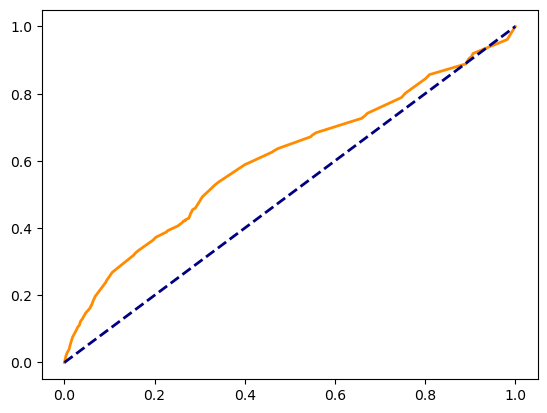

0.6053715154368826


In [51]:
calcAUC(data)

## 7
Логистическая регрессия принимает на вход только количественные признаки.

Добавим к нашим данным пол пациента, применив one hot encoding:

*Функции, которые могут пригодиться при решении: `pd.get_dummies(m.Sex, prefix='pol')`* 

In [52]:
pol_dummies = pd.get_dummies(m.Sex, prefix='pol')
data = pd.concat([data, pol_dummies], axis=1)
data

,AgeAtFirstClaim,CharlsonIndex,LengthOfStay,ClaimsTruncated,DaysInHospital,pol_F,pol_M,pol_N
MemberID,,,,,,,,
14723353,70.0,0.0,0.0,0.0,0.0,0,1,0
75706636,70.0,0.0,2.0,0.0,0.0,0,1,0
17320609,70.0,1.0,1.0,0.0,0.0,0,1,0
69690888,40.0,0.0,0.0,0.0,0.0,0,1,0
33004608,0.0,0.0,0.0,0.0,1.0,0,1,0
...,...,...,...,...,...,...,...,...
21382846,NaN,NaN,NaN,NaN,NaN,0,1,0
90655054,NaN,NaN,NaN,NaN,NaN,0,1,0
735535,NaN,NaN,NaN,NaN,NaN,1,0,0


## 8
Попытайтесь применить  one hot encoding к уже существующим в `data2` признакам или составить новые признаки по массиву `claims`.

In [7]:
data2=claims
provider_dummies = pd.get_dummies(data2.ProviderID, prefix='provider')
data2 = data2.join(provider_dummies)